# Hyperparameter Tuning Lab

### Lesson Objectives:
- Understand the difference between parameters and hyperparameters
- Understand why we tune hyperparameters
- Understand how hyperparameter tuning impacts the outcomes of your model
- Apply hyperparameter tuning to your model using gridsearch and randomsearch
- Select the "best" hyperparameters for your model

## Parameters vs Hyperparameters

We talk a lot about parameters and hyperparameters, but what are they?  What is the difference?

![](images/meetupconsumercreditdefaultvers2all-11-638.jpg)

<font size="5"><span style="color:red"> Why do we tune hyperparameters?</span></font>

//YOUR THOUGHTS HERE//

![Pile of data to stir (https://xkcd.com/1838/)](images/machine_learning_xkcd.png)

You can think of hyperparameters as little dials to adjust to make it easier for the machine learning model to learn

![](images/dials.png)

But how do we know what to adjust them to?!

## First let's talk data!

The [data](https://www.kaggle.com/jolasa/bay-area-bike-sharing-trips) we will be using today is taken from Kaggle. This dataset contains anonymized trips data of Lyft bike sharing system(Bay Wheels), in the Bay Area from January 2019 to May 2019.


We are going to use this data to create a model the predicts if the the member is a "brogrammer".  Everyone who is a male and lives in SF AND rides an electric bike is a Brogrammer.  This target has already been created for you.

![bikes](images/bikes.jpg) 
![the wiggle](images/wiggle.png)

### Let's read in the data and do some EDA


In [1]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyClassifier


from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


from sklearn.preprocessing import LabelEncoder

from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport

In [6]:
bike=pd.read_pickle('./data/bike.pkl.zip')
bike.head()

trip_duration_sec  start_station_id  end_station_id  bike_id  \
4               1128             124.0             5.0      877   
5               1388             243.0           247.0     3234   
6                920             202.0           220.0     3262   
7                725              44.0           121.0     2706   
8                488              21.0            64.0      860   

   member_birth_year  trip_duration_min          bg  month_April  \
4             1973.0              18.80  Brogrammer            1   
5             1997.0              23.13  Brogrammer            1   
6             1976.0              15.33  Brogrammer            1   
7             1973.0              12.08  Brogrammer            1   
8             1986.0               8.13  Brogrammer            1   

   month_Februrary  month_January  month_March  month_May  user_type_Customer  \
4                0              0            0          0                   0   
5                0              0            0          0                   1   
6                0              0            0          0                   0   
7                0              0            0          0                   1   
8                0              0            0          0                   0   

   user_type_Subscriber  
4                     1  
5                     0  
6                     1  
7                     0  
8                     1

In [7]:
bike.bg.value_counts()

Brogrammer     706660
Nice_person    240182
Name: bg, dtype: int64

In [8]:
bike.describe()

trip_duration_sec  start_station_id  end_station_id        bike_id  \
count      946842.000000     946842.000000   946842.000000  946842.000000   
mean          578.960272        138.468291      135.722913    3891.877124   
std           324.429294        112.670023      111.868923    1972.289709   
min            61.000000          3.000000        3.000000      11.000000   
25%           327.000000         47.000000       44.000000    2175.000000   
50%           512.000000        101.000000       98.000000    4560.000000   
75%           769.000000        238.000000      223.000000    5433.000000   
max          1583.000000        427.000000      427.000000    7196.000000   

       member_birth_year  trip_duration_min    month_April  month_Februrary  \
count      946842.000000      946842.000000  946842.000000    946842.000000   
mean         1984.673319           9.649340       0.226212         0.176227   
std            10.045458           5.407152       0.418378         0.381013   
min          1878.000000           1.020000       0.000000         0.000000   
25%          1980.000000           5.450000       0.000000         0.000000   
50%          1987.000000           8.530000       0.000000         0.000000   
75%          1992.000000          12.820000       0.000000         0.000000   
max          2001.000000          26.380000       1.000000         1.000000   

       month_January    month_March      month_May  user_type_Customer  \
count  946842.000000  946842.000000  946842.000000       946842.000000   
mean        0.182460       0.241813       0.173288            0.098418   
std         0.386224       0.428182       0.378496            0.297879   
min         0.000000       0.000000       0.000000            0.000000   
25%         0.000000       0.000000       0.000000            0.000000   
50%         0.000000       0.000000       0.000000            0.000000   
75%         0.000000       0.000000       0.000000            0.000000   
max         1.000000       1.000000       1.000000            1.000000   

       user_type_Subscriber  
count         946842.000000  
mean               0.901582  
std                0.297879  
min                0.000000  
25%                1.000000  
50%                1.000000  
75%                1.000000  
max                1.000000

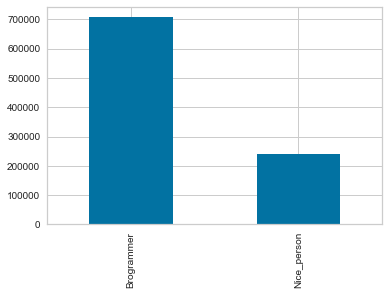

In [9]:
bike.bg.value_counts().plot(kind='bar')

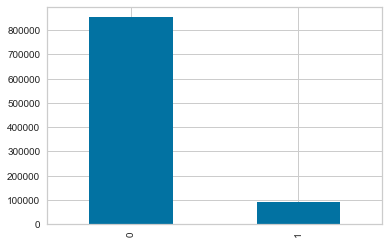

In [10]:
bike.user_type_Customer.value_counts().plot(kind='bar')

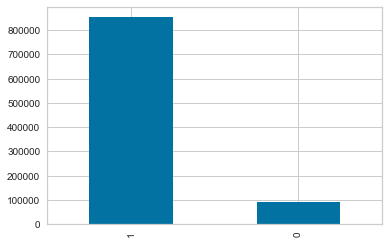

In [11]:
bike.user_type_Subscriber.value_counts().plot(kind='bar')

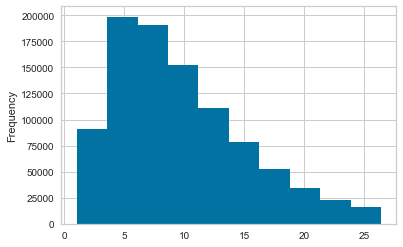

In [12]:
bike.trip_duration_min.plot(kind='hist')

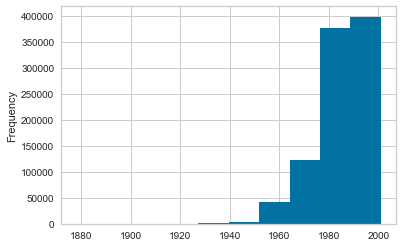

In [13]:
bike.member_birth_year.plot(kind='hist')

<font size="5"><span style="color:red"> What other visualizations should we create?</span></font>

## Start with a Baseline/Dummy Model

First we are going to start with a dummy model to predict if the user was a brogrammer.  In our dummy model we classify everything as the majority class.  
https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

In [14]:
#set random state for our notebook
import numpy as np
np.random.seed(107)

#set brogrammer as the target and use all other features as 
y = bike['bg']
#set features to all variables except brogrammer and trip in seconds
X = bike.drop(['bg', 'trip_duration_sec'], axis=1)

In [15]:
#split our data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.3 )

In [16]:
#check out the shape of our data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(662789, 12)
(662789,)
(284053, 12)
(284053,)


In [17]:
# DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

0.7463325506155541

<font size="5"><span style="color:red"> What does the "score" from the dummy classifier tell us about the predictive quality of our model?</span></font>

//YOUR THOUGHTS HERE//

#### Now that we have run our vanilla model let's create a nice looking confusion matrix using the yellowbrick package
[yellowbrick documentation](https://www.scikit-yb.org/en/latest/api/classifier/confusion_matrix.html)

/Users/seohohahm/anaconda3/lib/python3.7/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


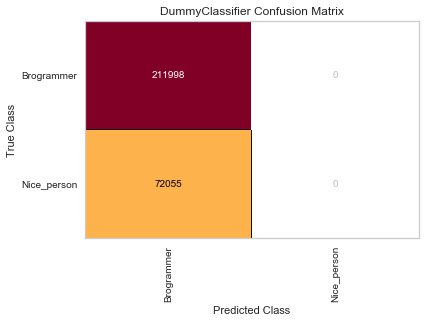

In [18]:
cm = ConfusionMatrix(dummy)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.poof()

<font size="5"><span style="color:red"> What does this confusion matrix tell us about what the dummy classifier did?</span></font>

//YOUR THOUGHTS HERE//

## Fitting a Vanilla Model

Now that we know what our dummy/baseline classifier does we are going to fit a vanilla decision tree model to predict if the user was a brogrammer.

In [19]:
#set random state for our notebook
import numpy as np
np.random.seed(107)

#set brogrammer as the target and use all other features as 
y = bike['bg']
#set features to all variables except brogrammer and trip in seconds
X = bike.drop(['bg', 'trip_duration_sec'], axis=1)

In [20]:
#split our data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.3 )

In [21]:
#check out the shape of our data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(662789, 12)
(662789,)
(284053, 12)
(284053,)


In [22]:
clf_DT = DecisionTreeClassifier()
clf_DT.fit(X_train, y_train)
clf_DT.score(X_test, y_test)

0.7587562884391293

<font size="5"><span style="color:red"> What does the "score" from the decision tree classifier tell us about the predictive quality of our model?</span></font>

//YOUR THOUGHTS HERE//

#### Now that we have run our vanilla model let's create a nice looking confusion matrix using the yellowbrick package
[yellowbrick documentation](https://www.scikit-yb.org/en/latest/api/classifier/confusion_matrix.html)

/Users/seohohahm/anaconda3/lib/python3.7/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


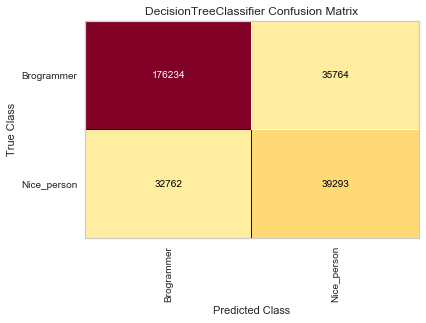

In [23]:
cm = ConfusionMatrix(clf_DT)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.poof()

<font size="5"><span style="color:red"> According to confusion matrix, how well did our decision tree classifier do?</span></font>

//YOUR THOUGHTS HERE//

In [24]:
y_pred=clf_DT.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Brogrammer       0.84      0.83      0.84    211998
 Nice_person       0.52      0.55      0.53     72055

    accuracy                           0.76    284053
   macro avg       0.68      0.69      0.69    284053
weighted avg       0.76      0.76      0.76    284053



<font size="5"><span style="color:red"> According to classification report, how well did our decision tree classifier do?</span></font>

//YOUR THOUGHTS HERE//

## Now onto Grid Search: Find the best hyperparameters for us!

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

A way for us to search over multiple hyperparameters for the given model to see if we can increase the accuracy of our model by "tuning" our hyperparameters in our decision tree model.

In [25]:
#first we set up a grid of hyperparameters we want to "search over"
param_grid = {
    'max_depth': [2, 5],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [8, 10],
}

#then we conduct the "search"
gs = GridSearchCV(estimator = clf_DT, param_grid = param_grid, 
                          cv = 5)
gs.fit(X_train, y_train)
#finally we find the best hyperparameters
gs.best_params_

{'max_depth': 5,
 'max_features': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 8}

###  WOW that took a while!!  Is there an easier way than just waiting for this to run?

## Luckily there is!  Let's check out the RandomizedSearchCV feature in sklearn
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html


In [26]:
#we can use the same exact param_grid we have already defined
param_grid = {
    'max_depth': [2, 5],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [8, 10],
}

#then we conduct the "search"
rs = RandomizedSearchCV(estimator = clf_DT,  param_distributions = param_grid, 
                          cv = 5)
rs.fit(X_train, y_train)
#finally we find the best hyperparameters
rs.best_params_

{'min_samples_split': 8,
 'min_samples_leaf': 3,
 'max_features': 2,
 'max_depth': 2}

### Great, that ran a bit faster.  But wait...why are our best params different now????

In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter.

## Fitting our Decision Tree Using Best Hyperparameters

In [27]:
#save our best model from the grid search
best_DT=gs.best_estimator_

#fit the data using the best model and look at the score given test data
best_DT.fit(X_train, y_train)
best_DT.score(X_test, y_test)

0.7463325506155541

<font size="5"><span style="color:red"> Our vanilla model had an accuracy score of 76%.  How did our tuned model do in comparison?</span></font>

//YOUR THOUGHTS HERE//

/Users/seohohahm/anaconda3/lib/python3.7/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


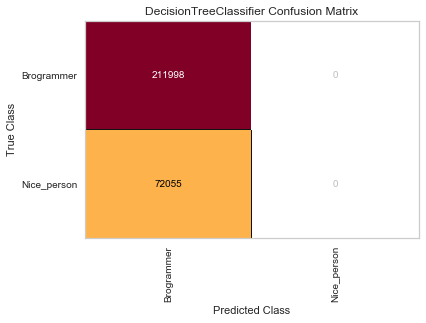

In [28]:
cm = ConfusionMatrix(best_DT)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.poof()

<font size="5"><span style="color:red"> According to confusion matrix, how well did our decision tree classifier do?</span></font>

//YOUR THOUGHTS HERE//

In [29]:
y_pred=best_DT.predict(X_test)
print(classification_report(y_test, y_pred))

/Users/seohohahm/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

  Brogrammer       0.75      1.00      0.85    211998
 Nice_person       0.00      0.00      0.00     72055

    accuracy                           0.75    284053
   macro avg       0.37      0.50      0.43    284053
weighted avg       0.56      0.75      0.64    284053



<font size="5"><span style="color:red"> According to classification report, how well did our decision tree classifier do?</span></font>

//YOUR THOUGHTS HERE//

<font size="5"><span style="color:red"> Does this mean that hyperparameter tuning isn't good?  What can we do now?</span></font>

//YOUR THOUGHTS HERE//

<font size="5"><span style="color:red"> Your Turn:  Now work in small groups to take one of the above next steps to increase the classification of brogrammers! </span></font>

//YOUR WORK HERE//

In [37]:
!pip install imblearn

In [45]:
from imblearn.over_sampling import SMOTE

ImportError: cannot import name '_safe_indexing' from 'sklearn.utils' (/Users/seohohahm/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py)

In [35]:
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

NameError: name 'SMOTE' is not defined